## NFL Object Detection: Object Detection

Dataset Source: https://huggingface.co/datasets/keremberke/nfl-object-detection

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install --upgrade pip
%pip install pytorch-lightning timm albumentations
%pip install torchvision evaluate
%pip install transformers datasets tensorboard
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for pytorch-lightning from https://files.pythonhosted.org/packages/26/b1/f0cbbabeceab4470bde31c025e4ce22084ff446a3f022100f032db9ea88b/pytorch_lightning-2.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for torchmetrics>=0.7.0 from https://files.pythonhosted.org/packages/d1/d3/3027b6b3936c5f139b64a7fa884a14eb485c8c19ae2e94bd1af9a44fa4c7/torchmetrics-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.7.0 from 

#### Mount Google Drive (For Evaluation)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Import Necessary Libraries

In [3]:
import os, sys, random, shutil, re, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import PIL.Image

from tqdm import tqdm

import datasets
from datasets import load_dataset

import torch
import torchvision

import transformers
from transformers import AutoImageProcessor, TrainingArguments
from transformers import AutoModelForObjectDetection, Trainer

import albumentations

import evaluate

!git lfs install

Git LFS initialized.


#### Enter HuggingFace Access Token

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


##### Display Versions of Relevant Libraries

In [5]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|", "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'*' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")
print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Torch".rjust(library_len),
      "|",
      torch.__version__.ljust(version_len),
      "|")
print("|",
      "Torch Vision".rjust(library_len),
      "|",
      torchvision.__version__.ljust(version_len),
      "|")
print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")
print("|",
      "Albumentations".rjust(library_len),
      "|",
      albumentations.__version__.ljust(version_len),
      "|")
print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")
print("|",
      "Evaluate".rjust(library_len),
      "|",
      evaluate.__version__.ljust(version_len),
      "|")
print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.6       |
|          NumPy | 1.22.4       |
|          Torch | 2.0.1+cu118  |
|   Torch Vision | 0.15.2+cu118 |
|       Datasets | 2.14.1       |
| Albumentations | 1.2.1        |
|    Transformer | 4.31.0       |
|       Evaluate | 0.4.0        |
+-------------------------------+


#### Load Dataset

In [6]:
data = load_dataset("keremberke/nfl-object-detection", "full")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6963
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1989
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 995
    })
})

#### Display Features for Sample

In [7]:
data['train'][12]

{'image_id': 56,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'width': 1280,
 'height': 720,
 'objects': {'id': [1075,
   1076,
   1077,
   1078,
   1079,
   1080,
   1081,
   1082,
   1083,
   1084,
   1085,
   1086,
   1087,
   1088,
   1089,
   1090],
  'area': [399,
   441,
   475,
   598,
   528,
   484,
   625,
   420,
   484,
   462,
   609,
   483,
   540,
   456,
   209,
   176],
  'bbox': [[1015.0, 137.0, 19.0, 21.0],
   [778.0, 139.0, 21.0, 21.0],
   [895.0, 112.0, 19.0, 25.0],
   [100.0, 548.0, 26.0, 23.0],
   [473.0, 387.0, 24.0, 22.0],
   [407.0, 367.0, 22.0, 22.0],
   [512.0, 263.0, 25.0, 25.0],
   [488.0, 180.0, 20.0, 21.0],
   [102.0, 265.0, 22.0, 22.0],
   [273.0, 182.0, 21.0, 22.0],
   [614.0, 305.0, 21.0, 29.0],
   [670.0, 266.0, 21.0, 23.0],
   [691.0, 259.0, 20.0, 27.0],
   [650.0, 373.0, 19.0, 24.0],
   [699.0, 337.0, 19.0, 11.0],
   [720.0, 342.0, 16.0, 11.0]],
  'category': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}

#### Define List of Category Names & Conversion Dictionaries

In [ ]:
categories = ['helmet',
              'helmet-blurred',
              'helmet-difficult',
              'helmet-partial',
              'helmet-sideline'
              ]

NUM_OF_CATEGORIES = len(categories)

id2label = {idx: tag for idx, tag in enumerate(categories)}
label2id = {tag: idx for idx, tag in enumerate(categories)}

print(f"List of Category Names:\n{categories}\n")
print(f"Number of Category Names: {NUM_OF_CATEGORIES}\n")
print(f"id2label:\n{id2label}\n")
print(f"label2id:\n{label2id}")

#### Visualize A Sample

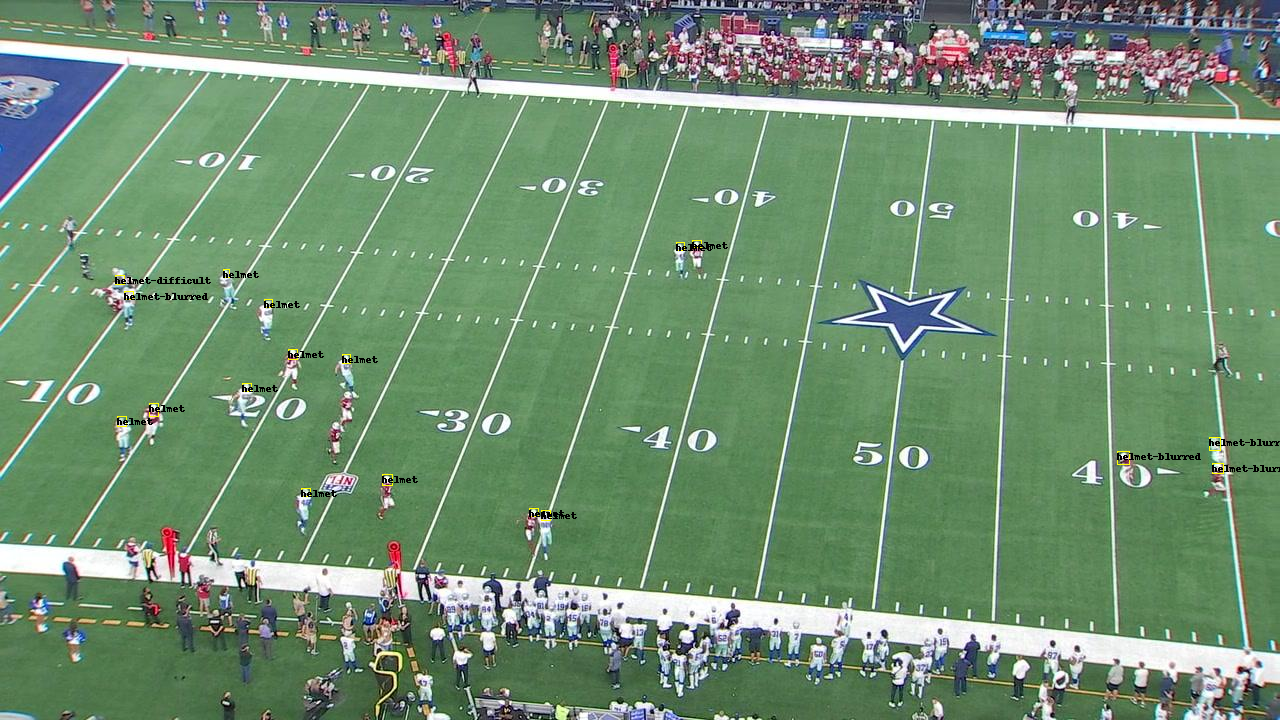

In [9]:
sample = data['train'][24]

sample_image = sample['image']
annotations = sample['objects']

draw = ImageDraw.Draw(sample_image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

sample_image

#### Basic Values/Constants

In [10]:
MODEL_CKPT = "hustvl/yolos-tiny"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-NFL_Object_Detection'

LR = 1e-5
WEIGHT_DECAY = 1e-4

NUM_OF_EPOCHS = 18
BATCH_SIZE = 8

STRATEGY = "steps"
REPORTS_TO = "tensorboard"

#### Instantiate Image Processor

In [11]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


#### Define Some Transformations for Images

In [12]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=['category']),
)

#### Create Function to Reformat Annotations Correctly

In [13]:
def reformat_annotations(image_id, category, area, bbox):
    annotations = []
    for x in range(0, len(category)):
        new_annotation = {
            "image_id": image_id,
            "category_id": category[x],
            "isCrowd": 0,
            "area": area[x],
            "bbox": list(bbox[x]),
        }
        annotations.append(new_annotation)

    return annotations

#### Combine Image & Annotation Transformations For Use On Batch of Samples

In [14]:
def transform_image_ann(samples):
    image_ids = samples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(samples["image"], samples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        { "image_id": id_, "annotations": reformat_annotations(id_, cat_, ar_, box_)
        } for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images,
                           annotations=targets,
                           return_tensors="pt")

#### Apply Image Transformations to Training Dataset

In [15]:
data['train'] = data['train'].with_transform(transform_image_ann)

data['train'][24]

{'pixel_values': tensor([[[-0.7650, -0.8164, -0.8678,  ..., -1.1932, -1.2445, -1.2788],
          [-0.7650, -0.7993, -0.8335,  ..., -1.1247, -1.1760, -1.2103],
          [-0.8164, -0.8335, -0.8849,  ..., -1.0562, -1.1075, -1.1418],
          ...,
          [-0.2171, -0.6794, -0.9363,  ...,  0.4679,  0.4679,  0.4851],
          [ 0.3652, -0.5082, -0.9363,  ...,  0.5536,  0.5364,  0.5536],
          [ 1.0159, -0.4739, -1.1418,  ...,  0.8104,  0.7419,  0.7077]],
 
         [[-1.5105, -1.4930, -1.4755,  ..., -0.5476, -0.5651, -0.5826],
          [-1.4930, -1.4755, -1.4580,  ..., -0.4776, -0.4951, -0.5126],
          [-1.5280, -1.5105, -1.4930,  ..., -0.4076, -0.4251, -0.4426],
          ...,
          [-0.8452, -1.1604, -1.1779,  ...,  0.6779,  0.7129,  0.7479],
          [-0.4426, -1.0728, -1.1604,  ...,  0.7829,  0.8179,  0.8529],
          [ 0.0826, -1.1253, -1.3704,  ...,  1.0105,  0.9930,  0.9405]],
 
         [[-1.5430, -1.5953, -1.5953,  ..., -0.9504, -0.9853, -1.0027],
          [-

#### Define Data Collator

In [16]:
def data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Define Model

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([6, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    MODEL_NAME,
    auto_find_batch_size=True,
    num_train_epochs=NUM_OF_EPOCHS,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    logging_steps=100,
    save_strategy=STRATEGY,
    save_steps=871,
    save_total_limit=12,
    fp16=True,
    remove_unused_columns=False,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [19]:
trainer = Trainer(
    model,
    args=args,
    data_collator=data_collator_fn,
    train_dataset=data['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/yolos-tiny-NFL_Object_Detection into local empty directory.


#### Train Model

In [20]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,4.702000
100,2.950600
200,2.679200
300,2.554200
400,2.528300
500,2.518900
600,2.447700
700,2.492000
800,2.406500
900,2.453300


TrainOutput(global_step=15678, training_loss=2.0486009953079485, metrics={'train_runtime': 12923.1901, 'train_samples_per_second': 9.698, 'train_steps_per_second': 1.213, 'total_flos': 3.8276224761609585e+18, 'train_loss': 2.0486009953079485, 'epoch': 18.0})

#### Push Model To Hub

In [21]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/24.8M [00:00<?, ?B/s]

Upload file runs/Jul30_17-44-01_94d35fcb3b97/events.out.tfevents.1690739055.94d35fcb3b97.678.0:   0%|         …

To https://huggingface.co/DunnBC22/yolos-tiny-NFL_Object_Detection
   5c346a0..00ccc89  main -> main

   5c346a0..00ccc89  main -> main

To https://huggingface.co/DunnBC22/yolos-tiny-NFL_Object_Detection
   00ccc89..3da8da7  main -> main

   00ccc89..3da8da7  main -> main



'https://huggingface.co/DunnBC22/yolos-tiny-NFL_Object_Detection/commit/00ccc893b10cbc87f8b232b38ae089a579b2893e'

#### Save Model

In [22]:
trainer.save_model()
trainer.save_state()

### Evaluate Model

#### Create Function to Reformat Evaluation Annotations Correctly

In [1]:
def eval_formatted_annotations(image_id, objects):
    annotations = []

    for x in range(0, len(objects["id"])):
        new_annotation = {
            "id": objects["id"][x],
            "category_id": objects["category"][x],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][x],
            "bbox": objects["bbox"][x],
        }
        annotations.append(new_annotation)

    return annotations

#### Save Images & Annotations into Proper Files

In [2]:
"""
Save images & annotations in format that
torchvision.datasets.CocoDetection expects
"""

def save_images_and_annotation_files(ds):
    output_json = {}
    path_output_ds = f"/content/drive/MyDrive/projects/NFL Obj Det/data"

    if not os.path.exists(path_output_ds):
        os.makedirs(path_output_ds)

    path_annotation = os.path.join(path_output_ds, "nfl_annos.json")
    categories_json = [
        {"supercategory" : "none", "id": id, "name": id2label[id]}
        for id in id2label]
    output_json['images'] = []
    output_json['annotations'] = []

    for sample in ds:
        anno = eval_formatted_annotations(sample["image_id"], sample["objects"])
        output_json["images"].append(
            {
                "id": sample["image_id"],
                "width": sample["image"].width,
                "height": sample["image"].height,
                "file_name": f"{sample['image_id']}.png",
            }
        )
        output_json["annotations"].extend(anno)
    output_json["categories"] = categories_json

    with open(path_annotation, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(ds["image"], ds["image_id"]):
        path_image = os.path.join(path_output_ds, f"{img_id}.png")
        im.save(path_image)

    return path_output_ds, path_annotation

#### Create Class to Ingest Datasets

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, annot_file):
        super().__init__(img_folder, annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

#### Apply Above-Defined Functions to Validation Dataset

In [ ]:
EVAL_MODEL_NAME = 'DunnBC22/yolos-tiny-NFL_Object_Detection'

eval_image_processor = AutoImageProcessor.from_pretrained(EVAL_MODEL_NAME)

path_output_ds, path_annot = save_images_and_annotation_files(data["validation"])
eval_ds_coco_format = CocoDetection(path_output_ds,
                                    eval_image_processor,
                                    path_annot)

#### Calculate Metrics

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(EVAL_MODEL_NAME)

module = evaluate.load("ybelkada/cocoevaluate",
                       coco=eval_ds_coco_format.coco)

eval_dataloader = torch.utils.data.DataLoader(
    eval_ds_coco_format,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=data_collator_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(eval_dataloader)):
        pixel_values = batch["pixel_values"]
        #pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        # forward pass
        outputs = model(pixel_values=pixel_values)#, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack(
            [
                target["orig_size"] for target in labels
            ],
            dim=0)

        results = eval_image_processor.post_process(outputs,
                                                    orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

#### Display Metrics

In [ ]:
print(results)

### Notes & Other Takeaways
****
- Since the results are far less than stellar, I decided to forego running inference using this model.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2106-00666, author = {Yuxin Fang and Bencheng Liao and Xinggang Wang and Jiemin Fang and Jiyang Qi and Rui Wu and Jianwei Niu and Wenyu Liu}, title = {You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection}, journal = {CoRR}, volume = {abs/2106.00666}, year = {2021}, url = {https://arxiv.org/abs/2106.00666}, eprinttype = {arXiv}, eprint = {2106.00666}, timestamp = {Fri, 29 Apr 2022 19:49:16 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2106-00666.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ nfl-competition_dataset, title = { NFL-competition Dataset }, type = { Open Source Dataset }, author = { home },
    howpublished = { \\url{ https://universe.roboflow.com/home-mxzv1/nfl-competition } }, url = { https://universe.roboflow.com/home-mxzv1/nfl-competition }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-01-18 },}
